<a href="https://colab.research.google.com/github/harishk30/DwarfResearch/blob/main/SAGAxCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install colossus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 1.5 MB/s eta 0:00:00


In [4]:
from colossus.halo import mass_so
from colossus.halo import mass_defs
from colossus.halo.concentration import concentration
from colossus.halo import profile_nfw
from colossus.halo import mass_adv
from colossus.cosmology import cosmology

In [ ]:
import pandas as pd
import astropy.coordinates
from astropy.coordinates import SkyCoord
import numpy as np
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo

In [5]:
from tqdm import tqdm

In [6]:
cosmology.setCosmology('planck15')

In [126]:
saga_hosts = '/content/drive/MyDrive/SummerProject/xSAGA-hosts_2021-09-28.parquet'
hosts = pd.read_parquet(saga_hosts, engine = 'auto')
satellites = pd.read_csv('/content/drive/MyDrive/SummerProject/xSAGA-lowz_2021-08-30.csv')

In [127]:
hosts = hosts.sort_values('mass_NSA', ascending = False)

In [9]:
#hosts = hosts[hosts['mass_GSE'] < 11]
satellite_coords = SkyCoord(satellites['ra'], satellites['dec'], unit = 'deg')
host_coords = SkyCoord(hosts['ra_NSA'], hosts['dec_NSA'], unit = 'deg')

In [10]:
host_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(157.16630741, 14.33506305), (247.43729829, 40.811602  ),
     (181.66246902, 28.17453522), ..., (214.9766162 , 51.89505011),
     (173.53809004, -1.59561628), (208.34098059, 20.94890988)]>

In [11]:
UniverseMachine_params = {
    "alpha": 1.957,
    "beta": 0.474,
    "gamma": -1.065,
    "delta": 0.386,
    "epsilon": -1.435,
    "M0": 12.081,
}

def SHMR(M_halo, params):
    """Stellar Mass Halo Mass Relation from Behroozi+19. See Appendix J."""

    x = M_halo - params["M0"]

    return (
        params["M0"] + params["epsilon"]
        - np.log10(10**(-params["alpha"]*x) + 10**(-params["beta"]*x))
        + 10**params["gamma"]*np.exp(-0.5 * (x / params["delta"])**2)
    )

In [12]:
halo_masses = np.arange(11, 15, 0.001)
stellar_masses = SHMR(halo_masses, UniverseMachine_params)

In [13]:
def virial_mass(sm):
  return halo_masses[np.argmin((sm - stellar_masses)**2)]

In [14]:
def virial_radius(sm, z):
  vm = virial_mass(sm)
  return mass_so.M_to_R(10 ** vm, z, 'vir')

In [15]:
def r_to_deg(r, z):
  return (r * u.kpc / cosmo.kpc_proper_per_arcmin(z)).to(u.arcmin)

In [ ]:
pairs = {}
assigned_satellites = set()
for id, host_coord in enumerate(tqdm(host_coords)):
  vr = virial_radius(hosts.iloc[id]['mass_NSA'], hosts.iloc[id]['z_NSA'])
  va = r_to_deg(vr, hosts.iloc[id]['z_NSA'])
  host_coord = SkyCoord(ra = [host_coords[id].ra], dec = [host_coords[id].dec])
  host_idx, satellite_idx, angsep, _ = host_coord.search_around_sky(satellite_coords, va)
  sep = (angsep * cosmo.kpc_proper_per_arcmin(hosts.iloc[id].z_NSA)).to(u.kpc)
  pairs[hosts.index[id]] = []
  for i, satellite_val in enumerate(host_idx):
    if(sep[i] > 36 * u.kpc):
      if(satellite_val not in assigned_satellites):
        pairs[hosts.index[id]].append(satellites.iloc[satellite_val]['objID'])
        assigned_satellites.add(satellite_val)

100%|██████████| 12769/12769 [44:23<00:00,  4.79it/s]


In [ ]:
for i in range(0, len(hosts)):
  if(hosts.iloc[i]['mass_NSA'] > 11):
    del pairs[hosts.index[i]]

In [ ]:
pairs

{350702: [1.237662528993952e+18,
  1.2376625289938214e+18,
  1.237662528993952e+18,
  1.237662635828839e+18,
  1.2376625289939523e+18],
 352469: [1.2376621988189312e+18,
  1.2376619491977467e+18,
  1.237662198818931e+18,
  1.2376621988188654e+18,
  1.2376619491976814e+18,
  1.237662198818931e+18,
  1.237662198818931e+18,
  1.2376619491977462e+18,
  1.2376621988188657e+18,
  1.2376621988189307e+18,
  1.237661949197681e+18,
  1.237662198818931e+18,
  1.2376619491976812e+18,
  1.237662198818931e+18,
  1.2376619491977462e+18,
  1.237662198818931e+18,
  1.2376621988189307e+18,
  1.2376621988189312e+18],
 522694: [1.2376682944497585e+18,
  1.2376682944497582e+18,
  1.2376682944497585e+18,
  1.2376682944498895e+18,
  1.2376682944497585e+18,
  1.2376679164906048e+18,
  1.2376679164906045e+18,
  1.2376682944497582e+18,
  1.2376679164906048e+18,
  1.2376682944498895e+18],
 123564: [1.237656494033273e+18,
  1.2376564940332736e+18,
  1.2376529420949266e+18,
  1.237656494033339e+18,
  1.23765294209

In [ ]:
import csv

w = csv.writer(open("hostpairs.csv", "w"))

for key, val in pairs.items():

    w.writerow([key, val])

In [128]:
hosts = hosts[hosts['mass_NSA'] <= 11]

In [129]:
import csv
import ast

def read_csv_as_dict(file_path):
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file)
        data = {}
        for row in reader:
            key = row[0]
            # Convert the string representation of a list to an actual list
            value = ast.literal_eval(row[1])
            data[key] = value
    return data

In [130]:
pairs = read_csv_as_dict('/content/hostpairs (1).csv')

In [131]:
for i in range(0, len(hosts)):
  if(hosts.iloc[i]['z_NSA'] < 0.02):
    if str(hosts.index[i]) in pairs:
      del pairs[str(hosts.index[i])]

In [132]:
hosts = hosts[hosts['z_NSA'] >= 0.02]

In [133]:
hosts

,z_NSA,ra_NSA,dec_NSA,M_r_NSA,M_g_NSA,mass_NSA,SERSIC_N_NSA,SERSIC_BA_NSA,SERSIC_PHI_NSA,ELPETRO_BA_NSA,PLATE,MJD,FIBERID,mass_GSE,mass_err_GSE,n_sats_in_300kpc,n_sats_in_150kpc,n_bright_sats_in_300kpc,N_unrelated_lowz,n_corr_sats_in_300kpc
NSAID,,,,,,,,,,,,,,,,,,,,
350702,0.025517,217.606577,11.927973,-22.025835,-21.269285,10.984602,5.257183,0.857721,120.447998,0.910484,1710,53504,317,11.326582,0.086736,3,2,3,0.023889,4.785405
352469,0.029077,224.150682,9.369723,-22.206125,-21.470406,10.968457,6.000000,0.665823,84.467041,0.697892,1715,54212,193,11.212667,0.087128,8,3,8,0.029606,13.155597
522694,0.023125,176.550767,20.391653,-21.987951,-21.289984,10.962545,6.000000,0.734939,12.358368,0.772986,2509,54180,492,11.173956,0.081876,5,2,5,0.035396,8.067079
123564,0.025188,344.508086,13.134494,-21.964119,-21.223104,10.961491,6.000000,0.679418,45.890747,0.731137,741,52261,12,11.232985,0.080872,5,2,5,0.023366,8.114398
402395,0.027054,123.936865,58.321011,-21.972540,-21.175783,10.959362,3.853148,0.785757,100.288239,0.841223,1873,54437,391,11.272670,0.085734,1,0,1,0.026347,1.470034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223240,0.028972,246.393312,40.787191,-17.915770,-15.755199,7.787176,0.500000,1.000000,117.718842,0.880065,1172,52759,457,9.649350,0.094504,0,0,0,0.029435,-0.178604
325710,0.025637,184.642937,12.855764,-18.330580,-17.478563,5.079427,1.436873,0.306668,147.662933,0.469843,1614,53120,356,9.752282,0.092904,0,0,0,0.024082,-0.213055
223226,0.029857,246.441544,39.609182,-8.395647,-9.839364,3.560767,0.709980,0.205326,156.155151,0.183755,1172,52759,435,10.985835,0.086237,3,0,3,0.030867,4.828380


In [134]:
n_sat = []

In [135]:
for i in range(0, len(hosts)):
  if str(hosts.index[i]) in pairs:
    n_sat.append(len(pairs[str(hosts.index[i])]))
  else:
    n_sat.append(0)

In [136]:
hosts['n_sat'] = n_sat

In [137]:
hosts['n_sat']

NSAID
350702     5
352469    18
522694    10
123564     7
402395     2
          ..
223240     0
325710     0
223226     0
208673     0
17347      0
Name: n_sat, Length: 10408, dtype: int64

In [138]:
bin1 = []
bin2 = []
bin3 = []
bin4 = []

In [139]:
for i in range(0, len(hosts)):
  val = hosts.iloc[i]
  if(val['mass_NSA'] < 9.5 and val['mass_NSA'] >= 9):
    bin1.append(val['n_sat'])
  elif(val['mass_NSA'] < 10 and val['mass_NSA'] >= 9.5):
    bin2.append(val['n_sat'])
  elif(val['mass_NSA'] < 10.5 and val['mass_NSA'] >= 10):
    bin3.append(val['n_sat'])
  else:
    bin4.append(val['n_sat'])

Text(0.5, 1.0, 'Average Satellites vs Mass')

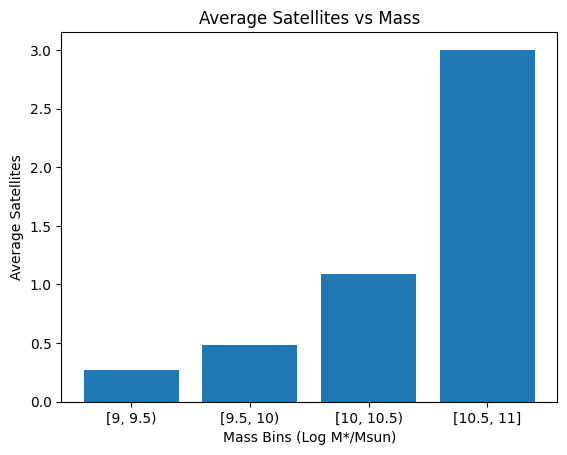

In [140]:
import matplotlib.pyplot as plt
groups = ['[9, 9.5)', '[9.5, 10)', '[10, 10.5)', '[10.5, 11]']
values = [sum(bin1)/len(bin1), sum(bin2)/len(bin2), sum(bin3)/len(bin3), sum(bin4)/len(bin4)]
plt.bar(groups, values)
plt.xlabel('Mass Bins (Log M*/Msun)')
plt.ylabel('Average Satellites')
plt.title('Average Satellites vs Mass')

Text(0, 0.5, 'Frequency')

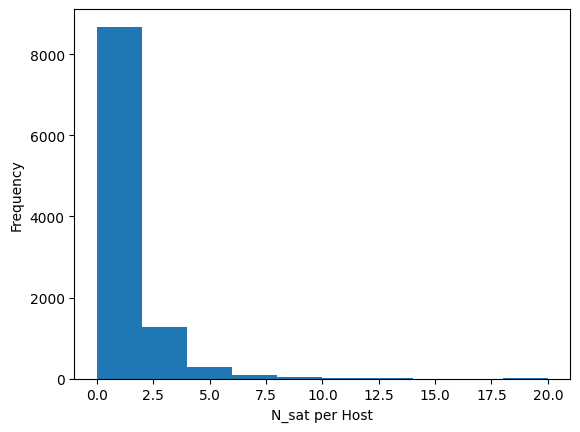

In [141]:
plt.hist(n_sat, bins = 10, range = (0, 20))
plt.xlabel('N_sat per Host')
plt.ylabel('Frequency')

In [142]:
hosts

,z_NSA,ra_NSA,dec_NSA,M_r_NSA,M_g_NSA,mass_NSA,SERSIC_N_NSA,SERSIC_BA_NSA,SERSIC_PHI_NSA,ELPETRO_BA_NSA,...,MJD,FIBERID,mass_GSE,mass_err_GSE,n_sats_in_300kpc,n_sats_in_150kpc,n_bright_sats_in_300kpc,N_unrelated_lowz,n_corr_sats_in_300kpc,n_sat
NSAID,,,,,,,,,,,,,,,,,,,,,
350702,0.025517,217.606577,11.927973,-22.025835,-21.269285,10.984602,5.257183,0.857721,120.447998,0.910484,...,53504,317,11.326582,0.086736,3,2,3,0.023889,4.785405,5
352469,0.029077,224.150682,9.369723,-22.206125,-21.470406,10.968457,6.000000,0.665823,84.467041,0.697892,...,54212,193,11.212667,0.087128,8,3,8,0.029606,13.155597,18
522694,0.023125,176.550767,20.391653,-21.987951,-21.289984,10.962545,6.000000,0.734939,12.358368,0.772986,...,54180,492,11.173956,0.081876,5,2,5,0.035396,8.067079,10
123564,0.025188,344.508086,13.134494,-21.964119,-21.223104,10.961491,6.000000,0.679418,45.890747,0.731137,...,52261,12,11.232985,0.080872,5,2,5,0.023366,8.114398,7
402395,0.027054,123.936865,58.321011,-21.972540,-21.175783,10.959362,3.853148,0.785757,100.288239,0.841223,...,54437,391,11.272670,0.085734,1,0,1,0.026347,1.470034,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223240,0.028972,246.393312,40.787191,-17.915770,-15.755199,7.787176,0.500000,1.000000,117.718842,0.880065,...,52759,457,9.649350,0.094504,0,0,0,0.029435,-0.178604,0
325710,0.025637,184.642937,12.855764,-18.330580,-17.478563,5.079427,1.436873,0.306668,147.662933,0.469843,...,53120,356,9.752282,0.092904,0,0,0,0.024082,-0.213055,0
223226,0.029857,246.441544,39.609182,-8.395647,-9.839364,3.560767,0.709980,0.205326,156.155151,0.183755,...,52759,435,10.985835,0.086237,3,0,3,0.030867,4.828380,0


In [143]:
def absolute_to_apparent(M, z):
  D_L = cosmo.luminosity_distance(0.6).value * 1e6
  mu = 5 * np.log10(D_L) - 5
  return M + mu

In [144]:
def g_r(Mr, Mg, z):
  mr = absolute_to_apparent(Mr, z)
  mg = absolute_to_apparent(Mg, z)
  return mg - mr

In [145]:
g_r_color = []
for i in range(0, len(hosts)):
  val = hosts.iloc[i]
  g_r_color.append(g_r(val['M_r_NSA'], val['M_g_NSA'], val['z_NSA']))

<ipython-input-144-2081d618248b>:4: RuntimeWarning: invalid value encountered in scalar subtract
  return mg - mr


In [146]:
hosts['g-r'] = g_r_color

(array([1.000e+00, 3.000e+00, 3.600e+01, 4.040e+02, 1.455e+03, 1.868e+03,
        2.933e+03, 3.428e+03, 2.480e+02, 1.100e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

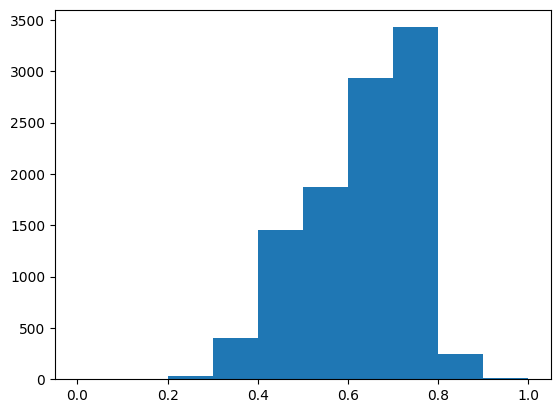

In [147]:
plt.hist(list(hosts['g-r']), range = (0, 1))

In [179]:
g_r_colors = np.array(list(hosts['g-r']))
satellites = np.array(list(hosts['n_sat']))
masses = np.array(list(hosts['mass_NSA']))
indices = np.array([i for i in range(0, len(hosts))])
mask = (g_r_colors >= 0) & (g_r_colors <= 1)
filtered_satellites = satellites[mask]
filtered_g_r_colors = g_r_colors[mask]
filtered_masses = masses[mask]
filtered_indices = indices[mask]

In [180]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_g_r_colors, bins)
average_satellites = [filtered_satellites[digitized == i].mean() if len(filtered_satellites[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [181]:
quartiles = np.percentile(filtered_masses, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
colors = ['blue', 'green', 'red', 'orange']

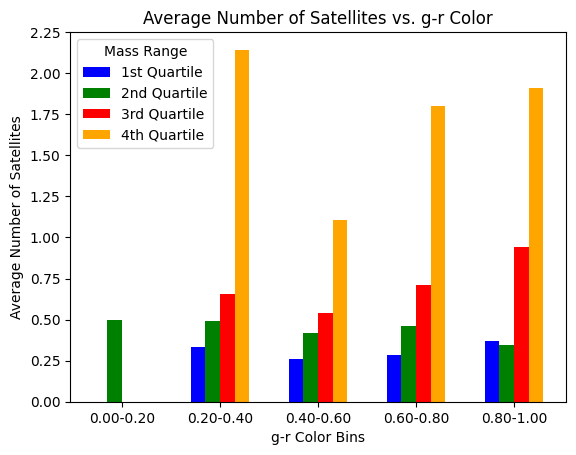

In [182]:
fig, ax = plt.subplots()

bar_width = 0.03
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses >= x) & (filtered_masses < mass_range[1])
    filtered_satellites_mass = filtered_satellites[mass_mask]
    filtered_g_r_colors_mass = filtered_g_r_colors[mass_mask]

    digitized_mass = np.digitize(filtered_g_r_colors_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('g-r Color Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. g-r Color')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

In [152]:
from astropy.io import fits
gse = fits.getdata('/content/drive/MyDrive/galSpecExtra-dr8.fits')
def byteorder(row):
  return row.byteswap().newbyteorder()
gse = pd.DataFrame(
        {
            "PLATE": byteorder(gse.PLATEID),
            "MJD": byteorder(gse.MJD),
            "FIBERID": byteorder(gse.FIBERID),
            "Metalicity": byteorder(gse.OH_P50),
            "SFR": byteorder(gse.SFR_TOT_P50),
        }
)

In [153]:
gse

,PLATE,MJD,FIBERID,Metalicity,SFR
0,266,51602,1,-9999.0,-0.520650
1,266,51602,2,-9999.0,-0.349722
2,266,51602,3,-9999.0,-9999.000000
3,266,51602,4,-9999.0,-1.124918
4,266,51602,5,-9999.0,-9999.000000
...,...,...,...,...,...
1843195,-1,-1,-1,0.0,0.000000
1843196,-1,-1,-1,0.0,0.000000
1843197,-1,-1,-1,0.0,0.000000
1843198,-1,-1,-1,0.0,0.000000


In [154]:
join_columns = ["PLATE", "MJD", "FIBERID"]
hosts_comb = hosts.join(gse.set_index(join_columns), on=join_columns, how="left")

In [155]:
hosts_comb['Metalicity']

NSAID
350702   -9999.000000
352469   -9999.000000
522694   -9999.000000
123564   -9999.000000
402395   -9999.000000
             ...     
223240   -9999.000000
325710   -9999.000000
223226   -9999.000000
208673       9.029759
17347    -9999.000000
Name: Metalicity, Length: 10408, dtype: float32

(array([3.800e+01, 1.100e+02, 2.740e+02, 5.640e+02, 9.070e+02, 1.038e+03,
        6.260e+02, 6.000e+01, 9.000e+00, 1.000e+00]),
 array([8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5]),
 <BarContainer object of 10 artists>)

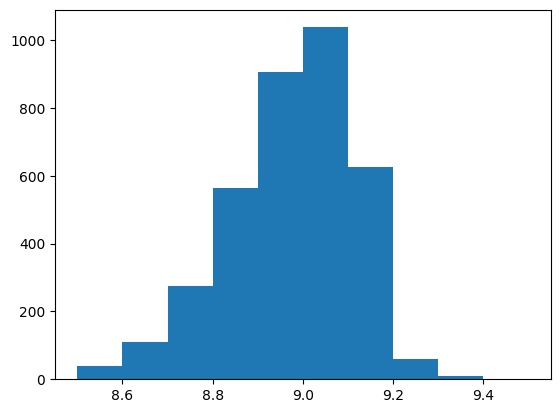

In [156]:
plt.hist(list(hosts_comb['Metalicity']), bins = 10, range = (8.5, 9.5))

In [157]:
metallicity = np.array(list(hosts_comb['Metalicity']))
mask = (metallicity >= 8.5) & (metallicity <= 9.5)
filtered_satellites_new = satellites[mask]
filtered_metallicity = metallicity[mask]
filtered_masses_new = masses[mask]

In [158]:
bins = np.linspace(8.5, 9.5, 6)
digitized = np.digitize(filtered_metallicity, bins)
average_satellites = [filtered_satellites_new[digitized == i].mean() if len(filtered_satellites_new[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [159]:
quartiles = np.percentile(filtered_masses_new, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
colors = ['blue', 'green', 'red', 'orange']

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


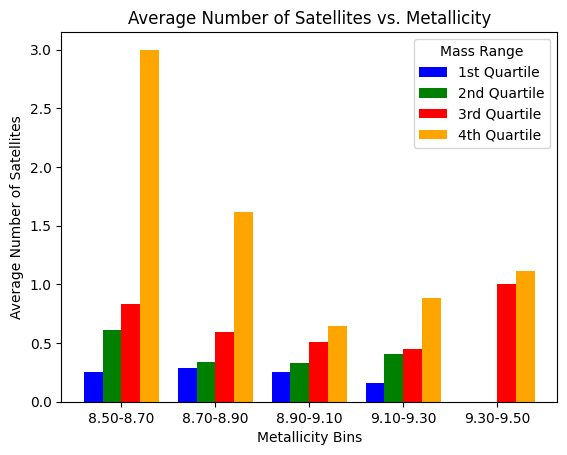

In [174]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_new >= x) & (filtered_masses_new < mass_range[1])
    filtered_satellites_mass = filtered_satellites_new[mass_mask]
    filtered_metallicity_mass = filtered_metallicity[mass_mask]

    digitized_mass = np.digitize(filtered_metallicity_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('Metallicity Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. Metallicity')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()

(array([633., 414., 277., 142.,  80.,  48.,  29.,  10.,   7.,   2.]),
 array([0.  , 0.13, 0.26, 0.39, 0.52, 0.65, 0.78, 0.91, 1.04, 1.17, 1.3 ]),
 <BarContainer object of 10 artists>)

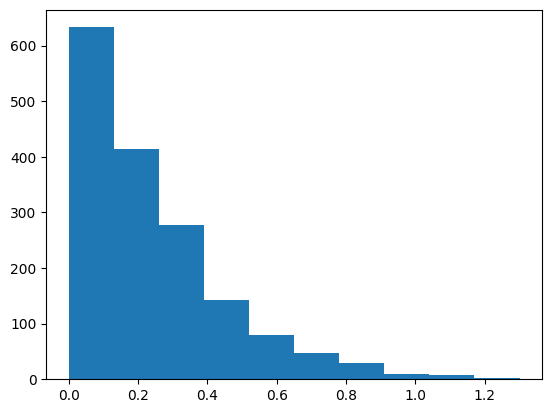

In [97]:
plt.hist(list(hosts_comb['SFR']), bins = 10, range = (0, 1.3))

In [183]:
sfr = np.array(list(hosts_comb['SFR']))
mask = (sfr >= 0) & (sfr <= 1)
filtered_satellites_sfr = satellites[mask]
filtered_sfr = sfr[mask]
filtered_masses_sfr = masses[mask]

In [184]:
bins = np.linspace(0, 1, 6)
digitized = np.digitize(filtered_sfr, bins)
average_satellites = [filtered_satellites_sfr[digitized == i].mean() if len(filtered_satellites_sfr[digitized == i]) > 0 else 0 for i in range(1, len(bins))]

In [185]:
quartiles = np.percentile(filtered_masses_sfr, [0, 25, 50, 75, 100])
mass_ranges = [(quartiles[i], quartiles[i+1]) for i in range(len(quartiles)-1)]
mass_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
colors = ['blue', 'green', 'red', 'orange']

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


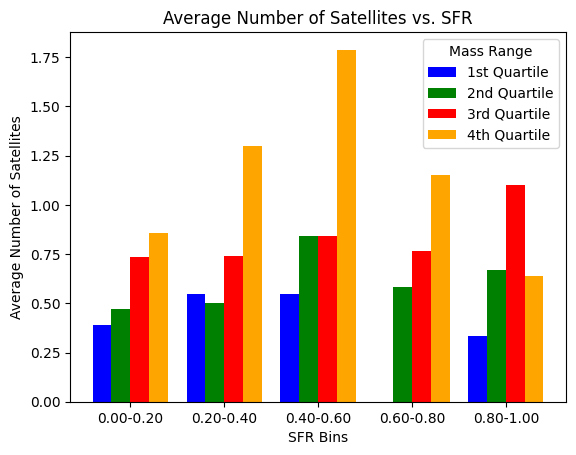

In [192]:
fig, ax = plt.subplots()

bar_width = 0.04
offset = -1.5 * bar_width
i = 0
for mass_range, color, label in zip(mass_ranges, colors, mass_labels):
    x = mass_range[0]
    if(i == 0):
      x = -np.inf
      i += 1
    mass_mask = (filtered_masses_sfr >= x) & (filtered_masses_sfr < mass_range[1])
    filtered_satellites_mass = filtered_satellites_sfr[mass_mask]
    filtered_sfr_mass = filtered_sfr[mass_mask]

    digitized_mass = np.digitize(filtered_sfr_mass, bins)
    average_satellites_mass = [filtered_satellites_mass[digitized_mass == i].mean() if len(filtered_satellites_mass[digitized_mass == i]) > 0 else 0 for i in range(1, len(bins))]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax.bar(bin_centers + offset, average_satellites_mass, width=bar_width, color=color, align='center', label=label)
    offset += bar_width

ax.set_xlabel('SFR Bins')
ax.set_ylabel('Average Number of Satellites')
ax.set_title('Average Number of Satellites vs. SFR')
ax.legend(title='Mass Range')

bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels)

plt.show()